In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import time
import random
import os

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("using cuda")
else:
    DEVICE = torch.device('cpu')
    print("using cpu")

using cuda


In [19]:
def switch_to_device(dataset, device = None):
    tensor_list_X, tensor_list_Y = [], []
    for x, y in dataset:
        tensor_list_X.append(x)
        tensor_list_Y.append(y)
    
    X = torch.stack(tensor_list_X)
    Y = torch.tensor(tensor_list_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return torch.utils.data.TensorDataset(X, Y)

In [20]:
def get_mnist_dl(batch_size_train = 256, batch_size_valid = 1024, device = None):
    #transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train = True, download = True, transform = transform)
    data_train = switch_to_device(data_train, device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000, 5000])

    data_test = MNIST('./datasets', train = False, download = True, transform = transform)
    data_test = switch_to_device(data_test, device)

    train_dl = DataLoader(data_train, batch_size = batch_size_train, shuffle = True)
    valid_dl = DataLoader(data_valid, batch_size = batch_size_valid, shuffle = False)
    test_dl = DataLoader(data_test, batch_size = batch_size_valid, shuffle = False)

    return train_dl, valid_dl, test_dl

In [21]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, 15.05)
  ax2.set_ylim(0.0, 1.05)

In [22]:
def clipping(x, max_norm):
    max_norm = float(max_norm)
    total_norm = torch.norm(x, p = 2)
    clip_coef = max_norm/(total_norm+1e-6)
    if clip_coef<1:
        return x*clip_coef
    return x

In [23]:
class Linear:
    @torch.no_grad()
    def __init__ (self, input_num, output_num, num_forward_grad, device):
        self.device = device
        self.input_num, self.output_num = input_num, output_num
        self.num_forward_grad = num_forward_grad
        self.weights = torch.normal(mean = torch.full((self.input_num, self.output_num), 0.), std = torch.full((self.input_num, self.output_num), 0.1)).to(device)
        self.bias = torch.normal(mean = torch.full((1, self.output_num), 0.), std = torch.full((1, self.output_num), 0.1)).to(device)
        #print(self.weights)
        #print(self.bias)
        #self.vectorw = torch.randn(self.num_forward_grad, self.input_num, self.output_num, device = self.device)
        #self.vectorb = torch.randn(self.num_forward_grad, 1, self.output_num, device= self.device)

    @torch.no_grad()
    def forward(self, input, da = None):
        self.vectorw = torch.randn(self.num_forward_grad, self.input_num, self.output_num, device = self.device)
        self.vectorb = torch.randn(self.num_forward_grad, 1, self.output_num, device= self.device)
        res = input @ self.weights + self.bias
        if torch.is_tensor(da):
            new_da = da @ self.weights + input @ self.vectorw + self.vectorb
        else:
            new_da = input @ self.vectorw + self.vectorb
        return res, new_da
    
    @torch.no_grad()
    def update(self, da, lr):
        g_w = da*self.vectorw
        g_w = torch.sum(g_w, dim = 0)/self.num_forward_grad
        #g_w = clipping(g_w, 1)
        g_b = da*self.vectorb
        g_b = torch.sum(g_b, dim = 0)/self.num_forward_grad
        #g_b = clipping(g_b, 1)
        self.weights -= lr*g_w
        self.bias -= lr*g_b

In [24]:
class Relu():
    @torch.no_grad()
    def __init__ (self, device):
        self.device = device

    @torch.no_grad()
    def forward(self, input, da):
        res = (torch.abs(input) + input) / 2.0
        mask = torch.zeros(da.shape).to(self.device)
        new_da = torch.where(da>0, da, mask)
        return res, new_da

In [25]:
class softmax():
    @torch.no_grad()
    def forward(self, input, da):
        batch_size = input.shape[0]
        x = torch.exp(input)
        y = torch.sum(x, axis = 1).reshape(batch_size, 1)
        res = x/y
        new_da = torch.empty([da.shape[0], input.shape[0], input.shape[1]], dtype = float).to(DEVICE)
        for i in range(batch_size):
            x = torch.diag(res[i]) - torch.outer(res[i], res[i])
            for j in range(da.shape[0]):
                new_da[j][i] = da[j][i].reshape((1, input.shape[1])) @ x
        return res, new_da


In [26]:
class CrossEntropy():
    @torch.no_grad()
    def forward(self, input, da, labels):
        loss = torch.sum(-(labels*torch.log(input))) / input.shape[0]
        new_da = torch.empty([da.shape[0], 1, 1], dtype = float).to(DEVICE)
        for i in range(da.shape[0]):
            new_da[i] = torch.sum(labels*(-1/input)*da[i]) / input.shape[0]
        return loss, new_da


In [27]:
class Softmax_CrossEntropy():
    @torch.no_grad()
    def forward(self, input, da, labels):
        exp_z = torch.exp(input)
        sum_exp_z = torch.sum(exp_z, dim=1).reshape(input.shape[0], 1)
        softmax_z = exp_z/sum_exp_z
        loss = torch.sum(-(labels*torch.log(softmax_z))) / input.shape[0]
        new_da = torch.empty([da.shape[0], 1, 1], dtype = float).to(DEVICE)
        for i in range(da.shape[0]):
            new_da[i] = torch.sum(da[i]*(softmax_z - labels))/input.shape[0]
        return loss, new_da

In [28]:
class MLP_Nets():
    def __init__(self, num_forward_grad, device):
        self.device = device
        self.fc_1 = Linear(input_num = 28*28, output_num = 1024, num_forward_grad = num_forward_grad, device = self.device)
        self.sigmoid_1 = Relu(self.device)
        self.fc_2 = Linear(input_num = 1024, output_num = 1024, num_forward_grad = num_forward_grad, device = self.device)
        self.sigmoid_2 = Relu(self.device)
        self.fc_3 = Linear(input_num = 1024, output_num = 10, num_forward_grad = num_forward_grad, device = self.device)
        #self.softmax = softmax()
        #self.CrossEntropy = CrossEntropy()
        self.CrossEntropy = Softmax_CrossEntropy()
        self.output = None
        self.loss = None

    def forward(self, input, labels):
        input = torch.reshape(input, (input.shape[0], 28*28))
        da = None
        output, da = self.fc_1.forward(input)
        output, da = self.sigmoid_1.forward(output, da)
        output, da = self.fc_2.forward(output, da)
        output, da = self.sigmoid_2.forward(output, da)
        output, da = self.fc_3.forward(output, da)
        self.output = output
        #output, da = self.softmax.forward(output, da)
        loss, da = self.CrossEntropy.forward(output, da, labels)
        self.loss = loss
        self.da = da
    
    def update(self, lr):
        self.fc_1.update(self.da, lr)
        self.fc_2.update(self.da, lr)
        self.fc_3.update(self.da, lr)
        

In [29]:
@torch.no_grad()
def get_acc(model, dl, lr):
  acc = []
  for X, y in dl:
    one_hot_y = torch.zeros(X.shape[0], 10).to(DEVICE)
    one_hot_y[[i for i in range(X.shape[0])], [k.item() for k in y]] = 1
    model.forward(X, one_hot_y)
    acc.append(torch.argmax(model.output, dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  return acc.item()

In [30]:
def run_experiment(model, train_dl, valid_dl, test_dl, max_epochs=20, lr = 1e-3):

  itr = -1
  stats = {'train-loss': [], 'valid-acc':[]}
  time_list = []
  for epoch in range(max_epochs):
    for X, y in train_dl:
        itr += 1
        one_hot_y = torch.zeros(X.shape[0], 10).to(DEVICE)
        one_hot_y[[i for i in range(X.shape[0])], [k.item() for k in y]] = 1
        start = time.time()
        model.forward(X, one_hot_y)
        model.update(lr)
        time_list.append(time.time()-start)
        stats['train-loss'].append((itr, model.loss.item()))

        if itr % 20 == 0:

          valid_acc = get_acc(model, valid_dl, lr)
          stats['valid-acc'].append((itr, valid_acc))
          s = f"{epoch}:{itr} [train] loss:{model.loss.item():.3f}, [valid] acc:{valid_acc:.3f}, time: {np.sum(time_list)/20} "
          print(s)
          time_list = []

  test_acc = get_acc(model, test_dl, lr)
  print(f"[test] acc:{test_acc:.3f}")
  return stats

In [31]:
max_epochs = 20
train_batch = 256
valid_batch = 1024
lr = 1e-4
num_forward_grad = 1

In [19]:
start = time.clock()
x = torch.randn(100, device = DEVICE)
a = torch.argsort(x)
time.clock() - start

0.0006063000000011698

0:0 [train] loss:7.565, [valid] acc:0.119, time: 0.00015006065368652343 
0:20 [train] loss:6.650, [valid] acc:0.125, time: 0.003538072109222412 
0:40 [train] loss:6.243, [valid] acc:0.100, time: 0.0032152414321899416 
0:60 [train] loss:6.140, [valid] acc:0.097, time: 0.0023546576499938964 
0:80 [train] loss:5.841, [valid] acc:0.103, time: 0.0033996224403381346 
0:100 [train] loss:5.739, [valid] acc:0.105, time: 0.00301743745803833 
0:120 [train] loss:5.602, [valid] acc:0.117, time: 0.0031532526016235353 
0:140 [train] loss:5.466, [valid] acc:0.119, time: 0.002951192855834961 
0:160 [train] loss:5.420, [valid] acc:0.126, time: 0.003400075435638428 
0:180 [train] loss:5.294, [valid] acc:0.125, time: 0.0036167025566101072 
0:200 [train] loss:5.211, [valid] acc:0.130, time: 0.0030965328216552733 
1:220 [train] loss:5.043, [valid] acc:0.132, time: 0.003550732135772705 
1:240 [train] loss:5.017, [valid] acc:0.131, time: 0.0030082941055297853 
1:260 [train] loss:4.902, [valid] acc:0.129, time

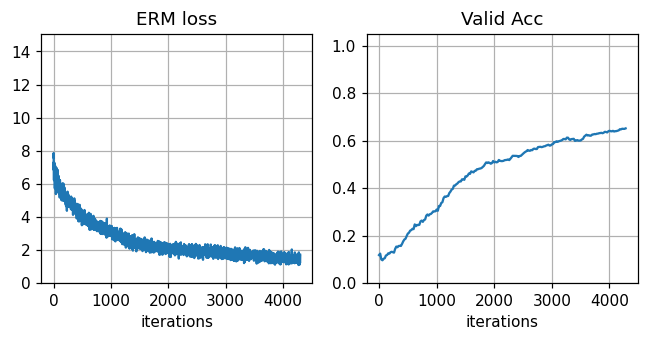

In [32]:
train_dl, valid_dl, test_dl = get_mnist_dl(batch_size_train=train_batch, batch_size_valid=valid_batch, device=DEVICE)

model = MLP_Nets(num_forward_grad, DEVICE)

stats = run_experiment(model, train_dl, valid_dl, test_dl, max_epochs=max_epochs, lr = lr)

print_stats(stats)